# TalTech'i programmeerimise ainete Discordi tekstide analüüs

Kasutatud meetodid:
- API requestide abil kanalite sisu hamkimine
- Andmete eeltöötlemine (algtüve võtmine, sõnade filtreerimine)
- Meelsusanalüüs
- Kvantitatiivsed mõõdikud (loetavus, ametlikkus ja informatiivsus)
- Võtmesõnade ekstrahheerimine
- Tekstikokkuvõtete genereerimine
- TODO: Võtmesõnade ning sisukokkuvõtete klasterdamine 

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from concat_configuration import ConcatConfiguration
from count_configuration import CountConfiguration
from textrank_analyzer import TextRankAnalyzer
from quantitative_metrics import QuantitativeMetrics
from cached_runner import CachedRunner
from IPython.display import display
import pandas as pd

In [2]:
%%capture
count_configuration = CountConfiguration()
count_runner = CachedRunner(count_configuration)
count_matrixes = count_runner.get_datasets(fresh=False, filter_function=count_configuration.all_words_have_context)

count_all = count_matrixes[0]
count_group_year = count_matrixes[1]
count_year_channels = count_matrixes[2]
count_flat = count_matrixes[3]
count_group_category = count_matrixes[4]

In [3]:
display(count_all)

,group,group_members,total_words,in_a_row,count_0,repetitions_0,count_1,repetitions_1,count_2,repetitions_2,count_3,repetitions_3,count_4,repetitions_4,count_5,repetitions_5,count_6,repetitions_6,count_7,repetitions_7,count_8,repetitions_8,count_9,repetitions_9,valence_only_negative,valence_mostly_negative,valence_only_neutral,valence_mostly_neutral,valence_only_mixed,valence_mostly_mixed,valence_only_positive,valence_mostly_positive
0,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,1,mina,80840,https,6513,kadri,5842,test,5239,kord,4885,ülesanne,4623,list,3613,kood,3371,aasta,3302,õige,2911,1625447,29681,746658,38954,0,125232,587919,20364
1,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,2,sebastian sõeruer,1536,tere hommikune,926,eelmine aasta,507,mina kood,394,järgmine nädal,272,järgmine aasta,250,järgmine kord,182,õige vastus,174,mina hetk,161,tere hommik,159,1625447,29681,746658,38954,0,125232,587919,20364
2,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,3,blacklargesquare |||| blacklargesquare,34,|||| blacklargesquare ||||,25,sebastian sõeruer mina,23,mina eelmine aasta,22,blank line require,20,faile with message,19,testing faile with,19,mina kood pilk,18,require between summary,17,between summary line,17,1625447,29681,746658,38954,0,125232,587919,20364
3,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,4,|||| blacklargesquare |||| blacklargesquare,25,blacklargesquare |||| blacklargesquare ||||,25,testing faile with message,19,require between summary line,17,blank line require between,17,line require between summary,17,maximum recursion depth exceede,15,code contains scenario that,9,cannot find symbo symbol,9,your code contains scenario,9,1625447,29681,746658,38954,0,125232,587919,20364


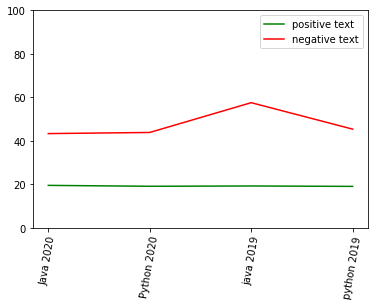

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_axis_for_emotion(emotion, df):
    groups = set()
    x = []
    y = []
    for index, row in df.iterrows():
        if row["group"] not in groups:
            groups.add(row["group"])
            y.append(100 * (row["valence_only_" + emotion] + row["valence_mostly_" + emotion]) / max(1, row["total_words"]))
            x.append(row["group"])
    return x, y

x1, y1 = get_axis_for_emotion("positive", count_group_year)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_year)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()

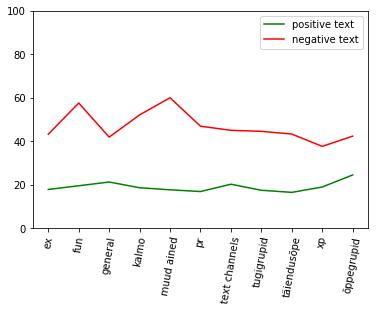

In [5]:
%matplotlib inline
x1, y1 = get_axis_for_emotion("positive", count_group_category)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_category)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()

<IPython.core.display.Javascript object>


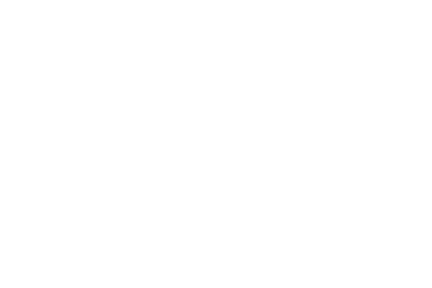

<IPython.core.display.Javascript object>


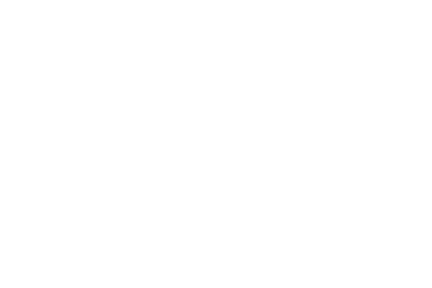

In [6]:
%matplotlib notebook
x1, y1 = get_axis_for_emotion("positive", count_year_channels)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_year_channels)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=14,10

In [7]:
%%capture
concat_configuration = ConcatConfiguration()
concat_runner = CachedRunner(concat_configuration)
concat_matrixes = concat_runner.get_datasets(fresh=False)

concat_all = concat_matrixes[0]
concat_year = concat_matrixes[1]
concat_year_channels = concat_matrixes[2]
concat_flat = concat_matrixes[3]
concat_group_category = concat_matrixes[4]

In [8]:
quantitative_metrics_table = QuantitativeMetrics().analyze(concat_year_channels)

In [9]:
display(quantitative_metrics_table)

,group,fres,gunning_fog,lexical_density,formality
0,Java 2020 ex,53.69,15.32,41.30,38.91
1,Java 2020 kalmo,49.30,15.90,42.90,40.87
2,Java 2020 pr,54.67,14.75,40.27,40.14
3,Java 2020 text channels,54.97,14.62,41.23,39.09
4,Python 2020 ex,55.09,14.71,41.55,39.34
5,Python 2020 fun,57.83,14.71,38.52,39.45
6,Python 2020 pr,58.13,13.88,40.64,38.80
7,Python 2020 text channels,58.05,13.73,41.56,39.09
8,Python 2020 tugigrupid,59.40,13.80,40.64,39.84
9,Python 2020 täiendusõpe,60.21,12.99,39.46,37.15


In [10]:
import numpy as np
import itertools

matrix = [
    ("FRES", quantitative_metrics_table["fres"]),
    ("GFOG", quantitative_metrics_table["gunning_fog"]),
    ("Density", quantitative_metrics_table["lexical_density"]),
    ("Formality", quantitative_metrics_table["formality"])
]

print("Correlations between:")
for (name1, list1), (name2, list2) in itertools.product(matrix, repeat = 2):
    print(name1 + " and " + name2 + " are " + str(abs(round(np.corrcoef(list1, list2)[0, 1], 2))))

Correlations between:
FRES and FRES are 1.0
FRES and GFOG are 0.89
FRES and Density are 0.71
FRES and Formality are 0.59
GFOG and FRES are 0.89
GFOG and GFOG are 1.0
GFOG and Density are 0.55
GFOG and Formality are 0.67
Density and FRES are 0.71
Density and GFOG are 0.55
Density and Density are 1.0
Density and Formality are 0.3
Formality and FRES are 0.59
Formality and GFOG are 0.67
Formality and Density are 0.3
Formality and Formality are 1.0


In [11]:
textrank_table = TextRankAnalyzer().analyze(concat_flat)

In [12]:
pd.set_option('display.max_colwidth', -1)
display(textrank_table)
pd.reset_option('display.max_colwidth')

,group,group_members,summary,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10,keyword_11,keyword_12,keyword_13,keyword_14,keyword_15,keyword_16,keyword_17,keyword_18,keyword_19
0,Java 2020 Kalmo / java,['Java 2020 Kalmo / java'],"}```, kuid annab teate, et ""method does not override method from its superclass"" ning "" method equals(oo.hide.Point) is never used"" kas keegi oskab seletada, mis on selle testi esimese rea mõte, kuidas see töötab ja miks ta võib mul feilida?",java,javat,eksam,equals,loeng,commit,test ülesanne aine,küsimus,lambda,idea,idee,kood,klass meetod,juht,metho,tester,https,array,getparameter,
1,Java 2020 PR / pr01-introduction,['Java 2020 PR / pr01-introduction'],kas see 2 ei peaks olema?\naa see on O.\nma vaatasin et see on 0.\nhttps://ained.ttu.ee/javadoc/data_structures/list.html.\noota kas Array ja ArrayList on sama asi?\nEi. https://ained.ttu.ee/javadoc/data_structures/array.html.\npushisin koodi giti aga ained.ttul ei ole vastust tulnud.\nsul on failinimi väikese tähega.\naga tester on linux.,kood,täht,list,arraylist,nimi,datastructure,ained,https,kord seotud windowsi failisysteem case insensitive tester,introduction,necessary,,,,,,,,,
2,Java 2020 PR / pr02-datastructures,['Java 2020 PR / pr02-datastructures'],"Üllis on kirjas, et kui sõne esineb listis paaritu number korda, siis jätta seda vahele, kuigi mallis viimases testis SPAM esineb 3 korda ja seda ikka prinditakse.\n@KiDDY , sul on tulemuses kaks elementi: ""story, Book"" ja ""]["".\nTänud, hoopis lihtsam asi nüüd 🙂 Kas elementide järjekord listis on oluline?",list,variant,järjekord,kord,java,kood,story,tulemus element,test,sõnum probleem whitespace,tänu,olev raamat,testonlyeven järjekorratundlik kiri,spam,,,,,,
3,Java 2020 PR / pr03-datatypes,['Java 2020 PR / pr03-datatypes'],"jah.\n`Name 'B' must match pattern '^[a-z][a-zA-Z0-9]*$'.` Ei mõista millest see tekib.\nbB.\nnimeta B bB.\nmod 8!\nmod 8!\nAitäh sulle @Kadri, nii kasulik sisend siia vestlusesse!\nMuidu jah, mõeldud ikka Math.pow(x).\nÜmardist pole vaja jah.\nmod 8!\nmis tähendab see mod?\nmod = % = jääk.",java,mõeldud,ülesanne olev viide javadoc leht vigane fiksisin sponsor task stackoverflowexception must match pattern,progeb,jumme nimi,pepel tehe,,,,,,,,,,,,,,
4,Java 2020 PR / pr04-subclasses,['Java 2020 PR / pr04-subclasses'],"Juhul kui kujund ei sisalda numbrit peab getNumber() tagastama Optional.empty().\nMeil on size, mis on siis raadius ja külje pikkus kummaski klassis, aga mis see number on.\nkui on int, siis ei saa null olla.\nmida rohkem, seda uhkem 🙂 hoopis parem, tänud 🙂 Ma ei muutnud midagi veel :D.",number,enum,optional,optionali,funktsioon,tänu,message,juht,kujund,täht,kontroll,uni antsar,getcategory string faile,baby developer lisa,input,,,,,
5,Java 2020 PR / pr06-reading-files,['Java 2020 PR / pr06-reading-files'],"2) Sinu küsimuse vastus on see, et pane neile tegevustele lihtsalt try catch(IOException) ümber, siis ei pea meetodi signatuuri muutma Pmst sarnaselt nagu selles näites: Jah, siin ülesandes piisab kui panna try catch über kohtades, kus IntelliJ seda nõuab, kuid testides ei tohiks korrektse koodi korral kood kunagi catch ploki sisse jõuda.",catch,test,ülesanne exceptionite,exceptioni,exception,readfiles meetod kord,näide,setfiletorida fail,intellij,file,reader,selge,readnextline hetk,push,tehtud,aine,,,,
6,Java 2020 PR / pr07-stream,['Java 2020 PR / pr07-stream'],"java.lang.AssertionError: expected: but was:\nKus probleem siin on?\nVabandus, polnud kohal 🙂 `java.lang.AssertionError: expected:<Optional[ee.taltech.iti0200.stream.Kitten@7b66322e]> but was:<Optional.empty>` See on tegelik error.\n@teacher Paluks tagasisidet `testFindFirstKittenWithGivenName` vea kohta, uniid=`eepuud` Ma pole teacher, aga sul võib olla selles viga.\n@karkat aitäh, ei näinud seda, aga mul läks nüüd läbi.\nAitäh, see lahendas probleemi 🙂",teacher,viga,java expecte nothing,probleem,testfindfirstkittenwithgivenname,b tegel